In [42]:
import keras as ks
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.python.keras.preprocessing import image as kp_image
import tensorflow as tf

In [3]:
tf.enable_eager_execution()
# kp_image.img_to_array(img)

In [74]:
def load_img(path_to_img):
    img=cv2.resize(cv2.imread(path_to_img),(224,224))
#     plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    img=img.astype(np.float32)
    return img.reshape(1,224,224,3)
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [75]:
content_layer = ['block5_conv2'] 
style_layer = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1','block5_conv1'
               ]

num_content_layers = len(content_layer)
num_style_layers = len(style_layer)

In [76]:
def model():
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    style_outputs = [vgg.get_layer(name).output for name in style_layer]
    content_outputs = [vgg.get_layer(name).output for name in content_layer]
    model_outputs = style_outputs + content_outputs
  # Build model 
    return tf.keras.models.Model(vgg.input, model_outputs)
    

In [77]:
def get_content_loss(base_content, target):
      return tf.reduce_mean(tf.square(base_content[0] - target[0]))

def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
#     height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))


In [78]:
def get_data(model,content_path,style_path):
    
    img_c=load_and_process_img(content_path)
    img_sty=load_and_process_img(style_path)
    
    c_feat=model(img_c)
    s_feat=model(img_sty)
    
    c_feats=[c for c in c_feat[num_style_layers:]]
    s_feats=[s for s in s_feat[:num_style_layers]]
    
    return c_feats,s_feats
    

In [79]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    image_feat=model(image)
    image_c=[c for c in image_feat[num_style_layers:]]
    image_s=[s for s in image_feat[:num_style_layers]]
    beta,alpha=loss_weights
    c_loss=alpha*get_content_loss(image_c,content_features)
    styl_loss=0
    for i in range(len(image_s)):
        styl_loss+=beta*get_style_loss(image_s[i],gram_style_features[i])/float(num_style_layers)
    total_loss=c_loss+styl_loss
    return total_loss,styl_loss,c_loss

def compute_grads(args):
    with tf.GradientTape() as gd:
        loss=compute_loss(**args)
    return gd.gradient(loss[0],args["image"]),loss

In [89]:
def run_style_transfer(content_path,style_path,num_iterations=1000,
                       content_weight=1,style_weight = 1e-1):
    m=model()
    for l in m.layers:
        l.trainable=False
    content_features,style_features = get_data(m, content_path, style_path)
    gram_style_features = [gram_matrix(i) for i in style_features]
    
    image=load_and_process_img(content_path)
    image=tf.contrib.eager.Variable(image, dtype=tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    arg = {
    'model': m,
    'loss_weights': loss_weights,
    'image': image,
    'gram_style_features': gram_style_features,
    'content_features': content_features
    }
    
    norm_means = np.array([103.939, 116.779, 123.68]*(224*224)).reshape(224,224,3)
    
    best_loss, best_img = float('inf'), None
    
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    
    
    for i in range(100):
        grads,loss=compute_grads(arg)
        opt.apply_gradients([(grads,image)])
#         clipped = tf.clip_by_value(image[0], min_vals, max_vals)
#         image.assign(clipped)
#         clipped = tf.clip_by_value(image, min_vals, max_vals)
#         image.assign([clipped])
        if loss[0] < best_loss:
          # Update best loss and best image from total loss. 
            best_loss = loss[0]
            best_img = deprocess_img(image.numpy())
            
        print(i," ",loss[0].numpy()," ",loss[1].numpy()," ",loss[2].numpy())

    return best_img, best_loss 

In [90]:
image,loss=run_style_transfer("./content.png","./style.png")

0   3766322000.0   3766322000.0   0.0
1   2370199300.0   2370197200.0   2050.6555
2   1334366600.0   1334363400.0   3257.4998
3   978707100.0   978703170.0   3888.927
4   826555500.0   826551360.0   4146.338
5   727372900.0   727368600.0   4325.016
6   669603260.0   669598700.0   4513.2817
7   643140700.0   643136000.0   4691.7114
8   620577660.0   620572800.0   4834.904
9   578429440.0   578424500.0   4926.346
10   527838100.0   527833120.0   4986.996
11   485169820.0   485164770.0   5042.394
12   448488800.0   448483680.0   5108.6694
13   412140900.0   412135700.0   5182.4976
14   377127100.0   377121860.0   5258.777
15   348522500.0   348517150.0   5331.888
16   327269250.0   327263840.0   5393.6133
17   311093220.0   311087780.0   5446.4683
18   297398700.0   297393200.0   5486.949
19   285459870.0   285454340.0   5521.377
20   274944300.0   274938720.0   5552.59
21   266083280.0   266077700.0   5586.371
22   258860060.0   258854450.0   5622.324
23   252707260.0   252701600.0   566

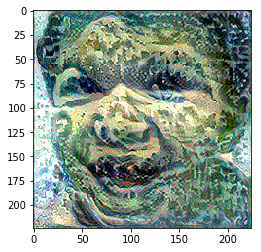

In [91]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

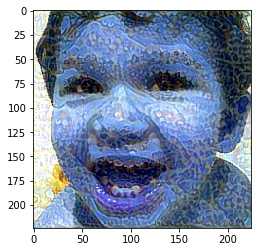

In [70]:
plt.imshow(image)